In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import json
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
#from transformers import AutoTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,Flatten, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization, concatenate
from tensorflow.keras.utils import Sequence,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
df_business = pd.read_csv('yelp_academic_dataset_business.csv')
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [9]:
photo_path = r"C:\Users\GINE\OneDrive - Loyalist College\Documents\AI&DS\term3\AISC2008 - Computer Vision 01\dataset\Yelp-Photos\Yelp Photos\yelp_photos\photos"
photos_df = pd.read_json('photos.json', lines=True)
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [10]:
photos_df['label' ].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [24]:
df_business.shape

(150346, 14)

In [25]:
photos_df.shape

(200100, 4)

In [26]:
image_dir = r"C:\Users\GINE\OneDrive - Loyalist College\Documents\AI&DS\term3\AISC2008 - Computer Vision 01\dataset\Yelp-Photos\Yelp Photos\yelp_photos\photos"

In [27]:
output_base = r"C:\Users\GINE\OneDrive - Loyalist College\Documents\AI&DS\term3\AISC2008 - Computer Vision 01\dataset\Yelp-Photos\Yelp Photos\yelp_photos\photos\processed"

In [28]:
valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
photos_df = photos_df[photos_df['label'].isin(valid_labels)]

In [12]:
# # comment
# import os
# import pandas as pd
# import shutil
# from sklearn.model_selection import train_test_split

# # Path where images are stored
# image_dir = r"C:\Users\srida\OneDrive - Loyalist College\CV\yelp_photos\photos"

# # Output base directory
# output_base = r"C:\Users\srida\OneDrive - Loyalist College\CV\yelp_photos\processed"

# # Load your dataframe (replace with your actual CSV if needed)
# # For example: photos_df = pd.read_csv('photos.csv')
# # Assuming you've already loaded it as photos_df

# # Filter to only use the valid labels
# valid_labels = ['inside', 'outside', 'food', 'drink', 'menu']
# photos_df = photos_df[photos_df['label'].isin(valid_labels)]

# # Create train/test split per label
# for label in valid_labels:
#     label_df = photos_df[photos_df['label'] == label]
    
#     # Split into train and test
#     train_df, test_df = train_test_split(label_df, test_size=0.2, random_state=42)

#     # Create target directories
#     train_label_dir = os.path.join(output_base, 'train', label)
#     test_label_dir = os.path.join(output_base, 'test', label)
#     os.makedirs(train_label_dir, exist_ok=True)
#     os.makedirs(test_label_dir, exist_ok=True)

#     # Move train images
#     for photo_id in train_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(train_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy(src, dst)

#     # Move test images
#     for photo_id in test_df['photo_id']:
#         src = os.path.join(image_dir, f"{photo_id}.jpg")
#         dst = os.path.join(test_label_dir, f"{photo_id}.jpg")
#         if os.path.exists(src):
#             shutil.copy(src, dst)

# print("✅ Image folders created and populated successfully.")

In [29]:
df = photos_df.merge(df_business[['business_id', 'categories']], on='business_id', how='left')

In [30]:
df.head()

,photo_id,business_id,caption,label,categories
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,"Restaurants, Pubs, Nightlife, American (Tradit..."
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,"Barbeque, Sandwiches, American (Traditional), ..."
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,"Live/Raw Food, Seafood, Restaurants, Cajun/Creole"
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,"Restaurants, Vegan, Food, Ice Cream & Frozen Y..."


In [31]:
df.drop(["business_id","caption"],axis=1,inplace=True)

In [32]:
df.head()

,photo_id,label,categories
0,zsvj7vloL4L5jhYyPIuVwg,inside,"Restaurants, Pubs, Nightlife, American (Tradit..."
1,HCUdRJHHm_e0OCTlZetGLg,outside,"Barbeque, Sandwiches, American (Traditional), ..."
2,vkr8T0scuJmGVvN2HJelEA,drink,"Live/Raw Food, Seafood, Restaurants, Cajun/Creole"
3,pve7D6NUrafHW3EAORubyw,food,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,H52Er-uBg6rNrHcReWTD2w,food,"Restaurants, Vegan, Food, Ice Cream & Frozen Y..."


In [33]:
df['label'].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [35]:
Processed_Files_Path = r"C:\Users\GINE\OneDrive - Loyalist College\Documents\AI&DS\term3\AISC2008 - Computer Vision 01\dataset\Yelp-Photos\Yelp Photos\yelp_photos\photos\processed"
Photos_path = r"C:\Users\GINE\OneDrive - Loyalist College\Documents\AI&DS\term3\AISC2008 - Computer Vision 01\dataset\Yelp-Photos\Yelp Photos\yelp_photos\photos"
TRAIN_DIR = os.path.join(Processed_Files_Path, "train")
TEST_DIR = os.path.join(Processed_Files_Path, "test")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [36]:
df = df.dropna(subset=['label', 'photo_id'])

In [37]:
df["image_path"] = df["photo_id"].apply(lambda x: os.path.join(Photos_path, f"{x}.jpg"))

In [38]:
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])

In [39]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(df["categories"].fillna(""))

In [40]:
metadata_seq = tokenizer.texts_to_matrix(df["categories"].fillna(""), mode='binary')
metadata_dim = metadata_seq.shape[1]

In [41]:
def preprocess_image(path, target_size=(224, 224)):
    image = cv2.imread(path)

    if image is None:
        return np.zeros((*target_size, 3))

    image = cv2.resize(image, target_size)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
    image = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    image[mask == 0] = 0

    return image.astype(np.float32) / 255.0

In [42]:
class AugmentedImageMetadataGenerator(Sequence):
    def __init__(self, image_paths, metadata, labels, batch_size=32, target_size=(224, 224), augment=True, **kwargs):
        super().__init__(**kwargs) 
        self.image_paths = image_paths
        self.metadata = metadata
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_meta = self.metadata[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = [self.load_and_augment_image(p) for p in batch_paths]
        return {"image_input": np.array(images, dtype=np.float32),"meta_input": np.array(batch_meta, dtype=np.float32)}, np.array(batch_labels, dtype=np.int32)

    def load_and_augment_image(self, path):
        image = preprocess_image(path, self.target_size)

        if self.augment:
            if np.random.rand() < 0.5:
                image = np.fliplr(image)
            if np.random.rand() < 0.5:
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((self.target_size[0]//2, self.target_size[1]//2), angle, 1)
                image = cv2.warpAffine(image, M, self.target_size)

        return image

In [43]:
X_img = df["image_path"].values
X_meta = metadata_seq
y = df["label_encoded"].values

In [44]:
X_img_train, X_img_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    X_img, X_meta, y, test_size=0.2, stratify=y, random_state=42)

In [45]:
from sklearn.utils import resample
import numpy as np
import pandas as pd

def balanced_sample(X_img, X_meta, y, samples_per_class=1678):
    df = pd.DataFrame({
        'img': X_img,
        'meta': list(X_meta),
        'label': y
    })

    unique_labels = np.unique(y)
    balanced_parts = []

    for label in unique_labels:
        class_df = df[df['label'] == label]
        if len(class_df) >= samples_per_class:
            class_sample = resample(class_df, n_samples=samples_per_class, random_state=42, replace=False)
        else:
            # If not enough samples, resample with replacement
            class_sample = resample(class_df, n_samples=samples_per_class, random_state=42, replace=True)
        balanced_parts.append(class_sample)

    balanced_df = pd.concat(balanced_parts).sample(frac=1, random_state=42).reset_index(drop=True)

    return (
        balanced_df['img'].values,
        np.stack(balanced_df['meta'].values),
        balanced_df['label'].values
    )


In [46]:
# samples_per_class = 1678
# total_train_samples = 5 * samples_per_class * 0.8  # ~6700
# total_val_samples = 5 * samples_per_class * 0.2  

In [47]:
# Call with samples_per_class explicitly
X_img_train_bal, X_meta_train_bal, y_train_bal = balanced_sample(
    X_img_train, X_meta_train, y_train, samples_per_class=1342
)

X_img_val_bal, X_meta_val_bal, y_val_bal = balanced_sample(
    X_img_val, X_meta_val, y_val, samples_per_class=336
)

In [48]:
# ✅ Use balanced data here
train_gen = AugmentedImageMetadataGenerator(X_img_train_bal, X_meta_train_bal, y_train_bal, augment=True)
val_gen = AugmentedImageMetadataGenerator(X_img_val_bal, X_meta_val_bal, y_val_bal, augment=False)

In [49]:
print(f"Metadata feature size: {metadata_dim}")
print(f"Train batches: {len(train_gen)}, Validation batches: {len(val_gen)}")

Metadata feature size: 500
Train batches: 210, Validation batches: 53


In [50]:
print(f"🔢 Total training samples: {len(train_gen) * train_gen.batch_size}")
print(f"🔢 Total validation samples: {len(val_gen) * val_gen.batch_size}")

🔢 Total training samples: 6720
🔢 Total validation samples: 1696


In [51]:
print("Train labels count:", len(y_train_bal))
print("Validation labels count:", len(y_val_bal))

Train labels count: 6710
Validation labels count: 1680


# Model

In [52]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import time

In [53]:
# Image input
image_input = Input(shape=(224, 224, 3), name='image_input')
base_model = VGG16(include_top=False, input_tensor=image_input, weights='imagenet')

In [54]:
# Freeze all layers in the base model
base_model.trainable = False

In [55]:
# Image feature extraction
x = base_model(image_input)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

In [56]:
# Metadata input
metadata_input = Input(shape=(metadata_dim,), name='meta_input')
m = Dense(128, activation='relu')(metadata_input)
m = BatchNormalization()(m)
m = Dropout(0.3)(m)


In [57]:
# Combine image + metadata branches
combined = Concatenate()([x, m])
z = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined)
z = Dropout(0.5)(combined)
z = BatchNormalization()(z)
output = Dense(len(label_encoder.classes_), activation='softmax')(combined)


In [58]:
# Final model
model = Model(inputs=[image_input, metadata_input], outputs=output)


In [59]:
# Compile
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 7, 7, 512)         │      14,714,688 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 25088)             │               0 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ meta_input (InputLayer)       │ (None, 500)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │      12,845,568 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          64,128 │ meta_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128)               │             512 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 640)               │               0 │ dropout[0][0],             │
│                               │                           │                 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 5)                 │           3,205 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 27,630,149 (105.40 MB)

 Trainable params: 12,914,181 (49.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [60]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_vgg_model.keras', save_best_only=True, monitor='val_loss')


In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
# Train (feature extraction)
start = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)
end = time.time()
print(f"Training time: {(end - start) / 60:.2f} mins")

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1462s 7s/step - accuracy: 0.6999 - loss: 0.9463 - val_accuracy: 0.8417 - val_loss: 0.5079 - learning_rate: 0.0010
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 1479s 7s/step - accuracy: 0.8632 - loss: 0.3938 - val_accuracy: 0.7851 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8990 - loss: 0.2749
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
210/210 ━━━━━━━━━━━━━━━━━━━━ 1488s 7s/step - accuracy: 0.8989 - loss: 0.2750 - val_accuracy: 0.7708 - val_loss: 0.7681 - learning_rate: 0.0010
Training time: 73.84 mins


In [63]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_gen)
print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")

210/210 ━━━━━━━━━━━━━━━━━━━━ 1130s 5s/step - accuracy: 0.8786 - loss: 0.3636
Train Accuracy: 0.8784, Train Loss: 0.3565


In [64]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.8437 - loss: 0.4869
Test Accuracy: 0.8417, Test Loss: 0.5079


In [65]:
# Predict probabilities
y_train_probs = model.predict(train_gen)
y_val_probs = model.predict(val_gen)

# Predicted class labels
y_train_pred = np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

# True labels
y_train_true = y_train_bal
y_val_true = y_val_bal


210/210 ━━━━━━━━━━━━━━━━━━━━ 1078s 5s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step


In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

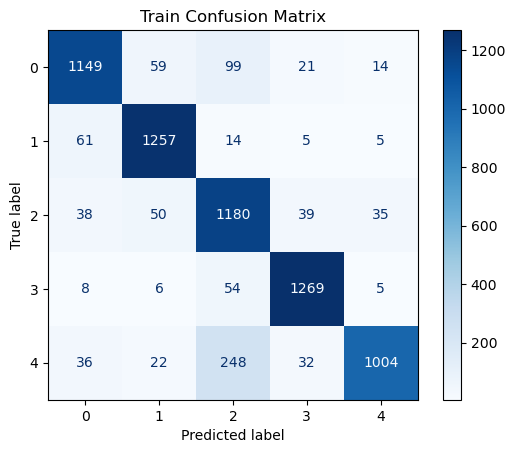

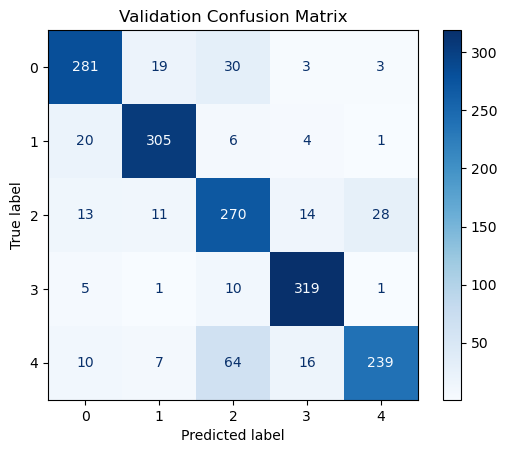

In [67]:
# Confusion Matrix for Train
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()

# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()


In [68]:
# Convert labels to one-hot if needed
from sklearn.preprocessing import label_binarize
num_classes = len(np.unique(y_train_true))

y_train_true_bin = label_binarize(y_train_true, classes=range(num_classes))
y_val_true_bin = label_binarize(y_val_true, classes=range(num_classes))

train_auc = roc_auc_score(y_train_true_bin, y_train_probs, average="macro", multi_class='ovr')
val_auc = roc_auc_score(y_val_true_bin, y_val_probs, average="macro", multi_class='ovr')

print(f"✅ Train AUC (macro): {train_auc:.4f}")
print(f"✅ Validation AUC (macro): {val_auc:.4f}")


✅ Train AUC (macro): 0.9826
✅ Validation AUC (macro): 0.9705


# Fine Tuning

In [69]:
from tensorflow.keras.models import load_model

In [70]:
# ---- Unfreeze top layers ----
base_model.trainable = True

In [71]:
# Keep first `fine_tune_at` layers frozen (unfreeze last layers only)
fine_tune_at = 4 # For VGG16, you can tune this (try 11–15)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True

In [72]:
# ---- Re-compile with lower LR for fine-tuning ----
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [73]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 7, 7, 512)         │      14,714,688 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 25088)             │               0 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ meta_input (InputLayer)       │ (None, 500)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │      12,845,568 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          64,128 │ meta_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128)               │             512 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 640)               │               0 │ dropout[0][0],             │
│                               │                           │                 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 5)                 │           3,205 │ concatenate[0][0]          │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 27,630,149 (105.40 MB)

 Trainable params: 27,628,869 (105.40 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [74]:
# ---- Train fine-tuning phase ----
start_time = time.time()
model.fit(train_gen, validation_data=val_gen, epochs=10,
          callbacks=[
              EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True),
              ReduceLROnPlateau(patience=2, monitor='val_loss'),
              ModelCheckpoint('vgg_finetuned.keras', save_best_only=True)
          ])
end_time = time.time()
elapsed_time = end_time - start_time

Epoch 1/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3718s 18s/step - accuracy: 0.8765 - loss: 0.3435 - val_accuracy: 0.8857 - val_loss: 0.3609 - learning_rate: 1.0000e-05
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3701s 18s/step - accuracy: 0.9208 - loss: 0.2299 - val_accuracy: 0.8804 - val_loss: 0.3609 - learning_rate: 1.0000e-05
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3710s 18s/step - accuracy: 0.9434 - loss: 0.1706 - val_accuracy: 0.8857 - val_loss: 0.3592 - learning_rate: 1.0000e-05
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3685s 18s/step - accuracy: 0.9594 - loss: 0.1245 - val_accuracy: 0.8875 - val_loss: 0.3415 - learning_rate: 1.0000e-05
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3687s 18s/step - accuracy: 0.9705 - loss: 0.0963 - val_accuracy: 0.8911 - val_loss: 0.3379 - learning_rate: 1.0000e-05
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3695s 18s/step - accuracy: 0.9813 - loss: 0.0761 - val_accuracy: 0.8935 - val_loss: 0.3202 - learning_rate: 1.0000e-05
Epoch 7/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 3707s 

In [75]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_gen)
print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")

210/210 ━━━━━━━━━━━━━━━━━━━━ 1091s 5s/step - accuracy: 0.9895 - loss: 0.0544
Train Accuracy: 0.9891, Train Loss: 0.0517


In [76]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {val_accuracy:.4f}, Test Loss: {val_loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.9008 - loss: 0.3149
Test Accuracy: 0.8935, Test Loss: 0.3202


In [77]:
# Predict probabilities
y_train_probs = model.predict(train_gen)
y_val_probs = model.predict(val_gen)

# Predicted class labels
y_train_pred = np.argmax(y_train_probs, axis=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

# True labels
y_train_true = y_train_bal
y_val_true = y_val_bal


210/210 ━━━━━━━━━━━━━━━━━━━━ 1091s 5s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step


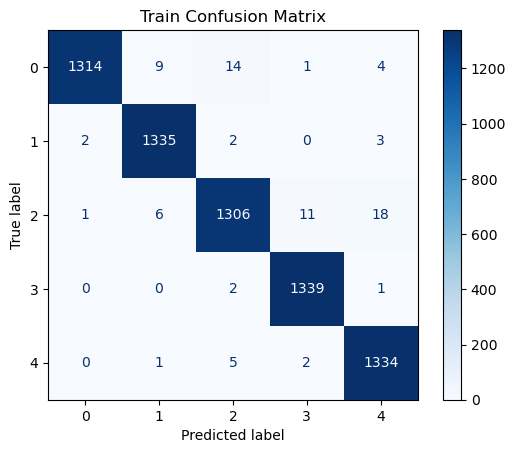

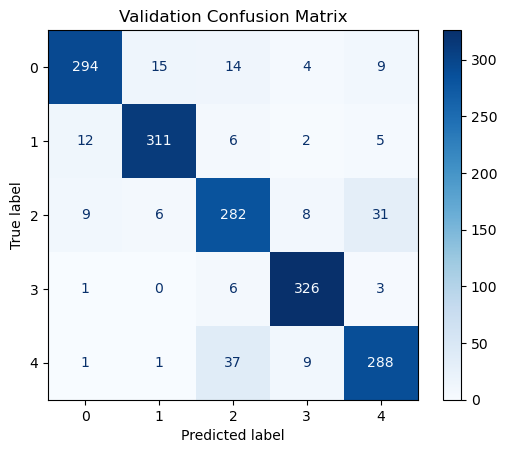

In [78]:
# Confusion Matrix for Train
cm_train = confusion_matrix(y_train_true, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Train Confusion Matrix")
plt.show()

# Confusion Matrix for Validation
cm_val = confusion_matrix(y_val_true, y_val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()


In [79]:
# Convert labels to one-hot if needed
from sklearn.preprocessing import label_binarize
num_classes = len(np.unique(y_train_true))

y_train_true_bin = label_binarize(y_train_true, classes=range(num_classes))
y_val_true_bin = label_binarize(y_val_true, classes=range(num_classes))

train_auc = roc_auc_score(y_train_true_bin, y_train_probs, average="macro", multi_class='ovr')
val_auc = roc_auc_score(y_val_true_bin, y_val_probs, average="macro", multi_class='ovr')

print(f"✅ Train AUC (macro): {train_auc:.4f}")
print(f"✅ Validation AUC (macro): {val_auc:.4f}")


✅ Train AUC (macro): 0.9998
✅ Validation AUC (macro): 0.9865


# 2 Rounds of iterative model development to build data centric AI

## 1st Round

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

In [3]:
import pandas as pd

# Load the JSON photo metadata
photos_df = pd.read_json('photos.json', lines=True)

# Optional: check for nulls or invalid labels
photos_df = photos_df[photos_df['label'].notnull()]

In [4]:
import os

photo_path = r"C:\Users\GINE\OneDrive - Loyalist College\Documents\AI&DS\term3\AISC2008 - Computer Vision 01\dataset\Yelp-Photos\Yelp Photos\yelp_photos\photos"

assert os.path.exists(photo_path), f"Image folder not found: {photo_path}"


In [8]:
# === Prepare VGG16-based image feature extractor ===
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
image_model = Model(inputs=base_model.input, outputs=x)

# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# ✅ Limit number of samples for faster testing
photos_df = photos_df.head(1000)

# === Encode labels ===
le = LabelEncoder()
y_encoded = le.fit_transform(photos_df['label'])
y_categorical = to_categorical(y_encoded)

# === Prepare image arrays ===
image_data = []
image_labels = []

for idx, row in photos_df.iterrows():
    try:
        img = load_img(os.path.join(photo_path, row['photo_id'] + ".jpg"), target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        image_data.append(img_array)
        image_labels.append(row['label'])
    except:
        continue

X = np.array(image_data)
y = to_categorical(le.transform(image_labels))

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === Feature extraction ===
X_train_feat = image_model.predict(X_train)
X_test_feat = image_model.predict(X_test)

# === Build classifier on top ===
from tensorflow.keras.models import Sequential
model1 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_feat.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Train baseline model ===
model1.fit(X_train_feat, y_train, validation_split=0.2, epochs=10, batch_size=32)

# === Evaluate baseline model ===
loss, acc = model1.evaluate(X_test_feat, y_test)
print(f"Baseline Accuracy: {acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step
Epoch 1/10


C:\Users\GINE\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4628 - loss: 1.3269 - val_accuracy: 0.7750 - val_loss: 0.9848
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6393 - loss: 0.9794 - val_accuracy: 0.7625 - val_loss: 0.8277
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7212 - loss: 0.8079 - val_accuracy: 0.7375 - val_loss: 0.7572
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7847 - loss: 0.6806 - val_accuracy: 0.7625 - val_loss: 0.7062
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7767 - loss: 0.6524 - val_accuracy: 0.7625 - val_loss: 0.6656
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7817 - loss: 0.5621 - val_accuracy: 0.7500 - val_loss: 0.6387
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7901 - loss: 0.5618 - val_accuracy: 0.7625 - val_loss: 0.6203
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8110 - loss: 0.4937 - val_accuracy: 0.7875 - val_loss: 0.5989
Ep

In [9]:
# === Imports (ensure these are at the top) ===
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Optional: Limit number of records for faster training ===
photos_df = photos_df.head(1000)  # Place this before image loading & feature extraction

# === Data Augmentation (note: applies only to original images) ===
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)  # augment on original image data (not features)

# === Define improved model using Functional API ===
input_layer = Input(shape=(X_train_feat.shape[1],))
x = Dense(512, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(y.shape[1], activation='softmax')(x)

model2 = Model(inputs=input_layer, outputs=output_layer)
model2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# === Train improved model ===
model2.fit(X_train_feat, y_train, validation_split=0.2, epochs=20, batch_size=32)

# === Evaluate improved model ===
loss2, acc2 = model2.evaluate(X_test_feat, y_test)
print(f"Improved Accuracy: {acc2:.4f}")


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4081 - loss: 1.5249 - val_accuracy: 0.5750 - val_loss: 1.3726
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5700 - loss: 1.1549 - val_accuracy: 0.5750 - val_loss: 1.2896
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6265 - loss: 0.9953 - val_accuracy: 0.5750 - val_loss: 1.2269
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7411 - loss: 0.7979 - val_accuracy: 0.5750 - val_loss: 1.1767
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7120 - loss: 0.7995 - val_accuracy: 0.5750 - val_loss: 1.1356
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6976 - loss: 0.8363 - val_accuracy: 0.5750 - val_loss: 1.1021
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7695 - loss: 0.7865 - val_accuracy: 0.6125 - val_loss: 1.0669
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8213 - loss: 0.5694 - val_accuracy: 0.6625 - val_loss

In [13]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

In [14]:
# Rebuild same model as Round 1 (VGG16 base + top classifier)
vgg_base = VGG16(include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation='softmax')(x)

full_model = Model(inputs=vgg_base.input, outputs=output)

# (Optional) Load trained weights — only if saved earlier
# full_model.load_weights('vgg_model_round1_weights.h5')

# Compile for evaluation (not needed for Grad-CAM, but good practice)
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
def get_gradcam_heatmap(model, image, class_index, last_conv_layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([image]))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    return heatmap


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


C:\Users\GINE\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor_66']]. Received: the structure of inputs=*
  warnings.warn(


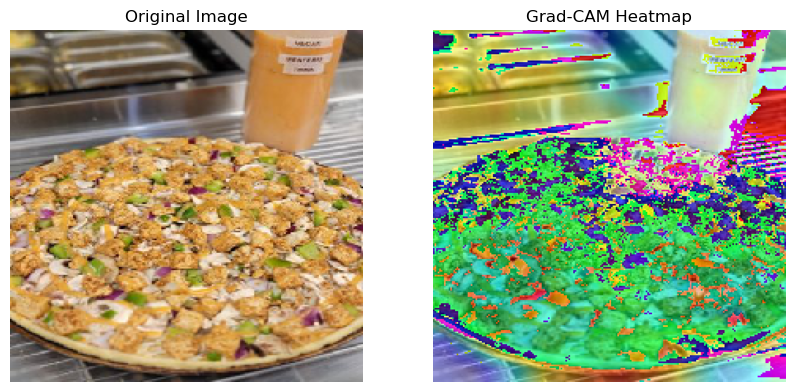

True Label: food
Predicted Label: drink


In [16]:
# Use a test image from X_test
img = X_test[0]  # shape (224, 224, 3)
true_label = np.argmax(y_test[0])
pred_label = np.argmax(full_model.predict(np.array([img])))

# Generate heatmap
heatmap = get_gradcam_heatmap(full_model, img, pred_label)

# Resize and superimpose heatmap on original image
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + (img * 255).astype('uint8')

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(superimposed_img.astype('uint8'))
plt.axis('off')
plt.show()

# Print labels
print(f"True Label: {le.inverse_transform([true_label])[0]}")
print(f"Predicted Label: {le.inverse_transform([pred_label])[0]}")
